Now we reach the final step, the model creation step. Once again our first step is importing the data and libraries we will use. We can first to look see the what columns null, and we can see some of the firearms columns are blank. Since the counties which are empty are smaller counties (due to the CDC not showing data rows if the value is under 10), I have decided to fill those values with the state average. There is a coorelation between population density and firearms ownership so these averages are likley lower then the county's actual values. 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor 

In [7]:
df = pd.read_csv('adjusted_data.csv')
df

,County,Poverty %,Poverty % (U18),MedHHInc,MedHHInc_log,PopDen_log,PopDen,Firearms %,Firearms_adj,Homicide_log,Homicide_adj
0,"Abbeville County, SC",14.8,21.2,49485,10.809425,2.963850,19.372405,0.843137,1.571356,-0.218219,0.803950
1,"Acadia Parish, LA",20.6,28.7,44648,10.706565,3.607462,36.872362,0.626087,1.052136,0.050823,1.052136
2,"Accomack County, VA",16.2,25.7,50949,10.838580,3.337049,28.135968,0.563636,0.857678,0.173686,1.189682
3,"Ada County, ID",8.7,9.1,79345,11.281561,5.098082,163.707537,0.568807,1.027765,-1.959682,0.140903
4,"Adair County, OK",20.8,28.5,43371,10.677546,2.700197,14.882667,0.500000,0.737092,-0.104372,0.900890
...,...,...,...,...,...,...,...,...,...,...,...
1681,"York County, SC",9.7,12.4,73466,11.204578,4.988461,146.710521,0.622066,0.947678,-0.758272,0.468475
1682,"York County, VA",5.1,6.1,97500,11.487608,5.519355,249.474195,0.547368,0.703433,-1.211984,0.297606
1683,"Yuba County, CA",15.6,21.9,60764,11.014753,3.831227,46.119104,0.503497,0.868902,-0.465947,0.627540
1684,"Yukon-Koyukuk Census Area, AK",23.7,32.1,44934,10.712950,-4.243164,0.014362,0.575758,3.150181,0.842078,2.321186


In [8]:
df.isnull().sum()
#check the null values

County              0
Poverty %           0
Poverty % (U18)     0
MedHHInc            0
MedHHInc_log        0
PopDen_log          0
PopDen              0
Firearms %         30
Firearms_adj       30
Homicide_log        0
Homicide_adj        0
dtype: int64

In [9]:
df_state = df.copy()
df_state['State'] = df['County'].str.split(',', expand = True)[1]
df_state = df_state[['State','Firearms %','Firearms_adj']].groupby(by = ['State']).mean()
df_state
#the averages of the firearm ownership for each state

,Firearms %,Firearms_adj
State,,
AK,0.598871,2.535053
AL,0.718963,1.148195
AR,0.643328,1.158747
AZ,0.579009,1.388721
CA,0.440778,0.741611
CO,0.550072,1.271474
CT,0.310593,0.384898
DC,0.225108,0.141965
DE,0.471593,0.603191


In [10]:
null_list = df[df['Firearms %'].isnull()].index.to_list()

df['Imputed Data (Firearms)'] = False
df.loc[null_list, 'Imputed Data (Firearms)'] = True

for i in null_list: 
    state = df.loc[i,'County'].split(',')[1]
    #print(state)
    df.loc[i,'Firearms %'] = df_state.loc[state, 'Firearms %']
    df.loc[i,'Firearms_adj'] = df_state.loc[state, 'Firearms_adj']
    
#replace the null values with the state averages

Now we can look at the coorelations between all the variables. To avoid colinearity, we would not want to have multiple columns which have a high of coorelation, this would make our model inaccurate and prone to overfitting. We can also see which fields coorelate highly with our 'Homicide_log' and 'Homicide_adj.' We can see that 'Homicide_log' tends to have a higher coorelation with all the variables so I will use that column as the Response Variable. 

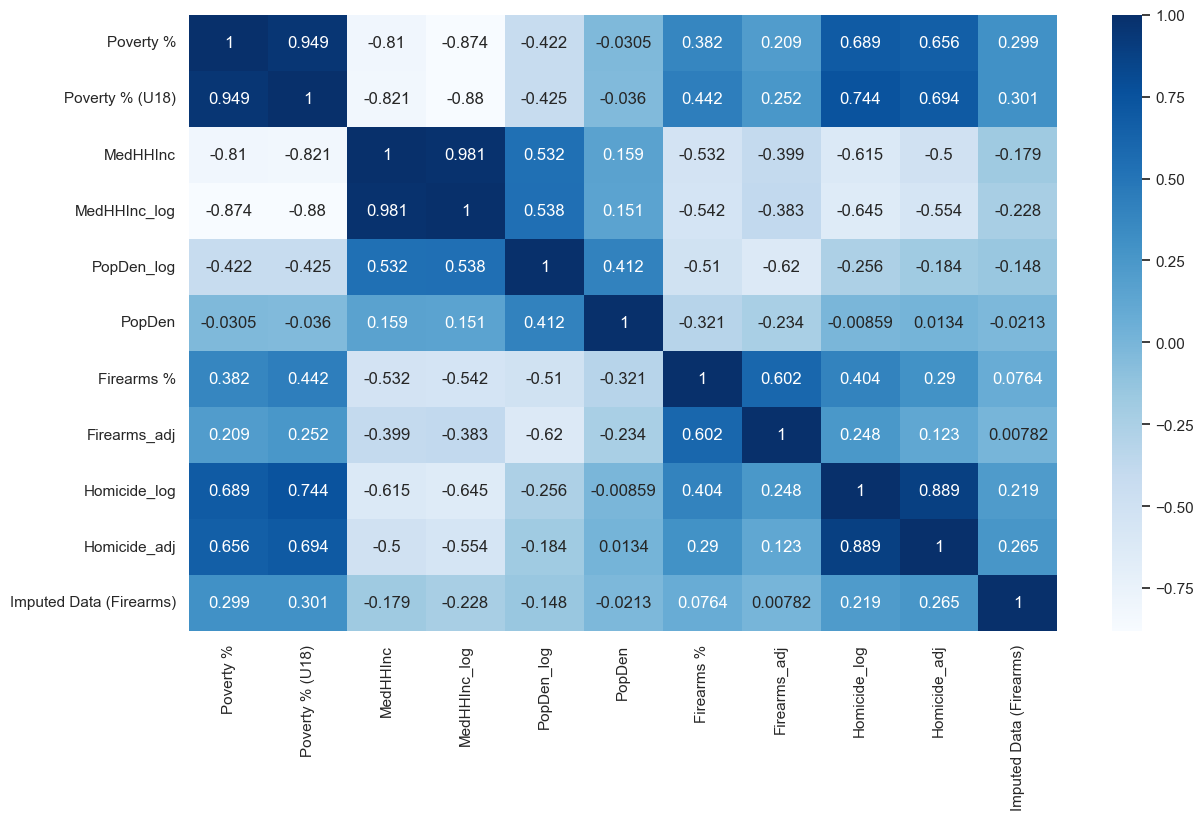

In [11]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.3g')
#check coorelations between the fields

## Linear Regression

Next I will split the data into training and testing sets, and go through the feature selection process. To do this I have created a loop to pick only one of the variables from each category. The loop will create a list of three variables (one from each list) and then display the mean cross validation score, as well as the variance of the scores. I will then proceed with the best scoring set of variables. 

In [12]:
df_X_train, df_X_test, y_train, y_test = train_test_split(df,df.Homicide_log, test_size=0.25, random_state=321)

In [16]:
PD_list = ['PopDen_log','PopDen'] #population density variables
Inc_list = ['MedHHInc','MedHHInc_log','Poverty %', 'Poverty % (U18)'] #income and poverty variables
FA_list = ['Firearms %','Firearms_adj'] #Firearm ownership variables 


In [19]:
for i in PD_list:
    for j in Inc_list:
        for k in FA_list:
            print(i,j,k)
            model = LinearRegression()
            scores = cross_val_score(model, df_X_train[[i,j,k]], y_train, cv = 5)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#Loop used for feature selection             

PopDen_log MedHHInc Firearms %
Accuracy: 0.41 (+/- 0.16)
PopDen_log MedHHInc Firearms_adj
Accuracy: 0.40 (+/- 0.17)
PopDen_log MedHHInc_log Firearms %
Accuracy: 0.45 (+/- 0.16)
PopDen_log MedHHInc_log Firearms_adj
Accuracy: 0.45 (+/- 0.16)
PopDen_log Poverty % Firearms %
Accuracy: 0.51 (+/- 0.10)
PopDen_log Poverty % Firearms_adj
Accuracy: 0.51 (+/- 0.10)
PopDen_log Poverty % (U18) Firearms %
Accuracy: 0.58 (+/- 0.10)
PopDen_log Poverty % (U18) Firearms_adj
Accuracy: 0.58 (+/- 0.10)
PopDen MedHHInc Firearms %
Accuracy: 0.16 (+/- 1.00)
PopDen MedHHInc Firearms_adj
Accuracy: 0.19 (+/- 0.82)
PopDen MedHHInc_log Firearms %
Accuracy: 0.22 (+/- 0.91)
PopDen MedHHInc_log Firearms_adj
Accuracy: 0.25 (+/- 0.76)
PopDen Poverty % Firearms %
Accuracy: 0.38 (+/- 0.51)
PopDen Poverty % Firearms_adj
Accuracy: 0.40 (+/- 0.36)
PopDen Poverty % (U18) Firearms %
Accuracy: 0.46 (+/- 0.40)
PopDen Poverty % (U18) Firearms_adj
Accuracy: 0.48 (+/- 0.31)


We can see that PopDen_log and Poverty % (U18) preform the best. While the Firearms_adj and Firearms % are about the same so I decided to use Firearms %. I also decided to scale the data so we can see the coefficents and therefore assess which one has the most effect on the result. When running the model on the entire training set we get a R2 score and adjusted R2 of .58. Next I decided to graph the residuals against the variables to see if there is room for improvement in the model. 

In [20]:
scaler  = MinMaxScaler((0,1))
#Scale the data and train the model on the entire dataset.

atts = ['PopDen_log' ,'Poverty % (U18)' ,'Firearms %']

X_train = scaler.fit_transform(df_X_train[atts])
model = LinearRegression()

model.fit(X_train,y_train)
y_pred = model.predict(X_train)
#train the model on the entire training set 

df_X_train['Pred'] = y_pred
df_X_train['res'] = y_train-y_pred
#Created the residuals and predicted column for furhter analysis. 

model.score(X_train,y_train)

0.5833580838756117

In [21]:
1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
#adjusted R2 score

0.5823660793134108

From our coefficents we can see that Poverty % (U18) has the highest coefficent value. This would indicate it is the most significant in determining our homicide rate. 

In [22]:
model.coef_

array([0.98299758, 3.26549202, 0.70637327])

After graphing the residuals against the variables used we can see that some data modification to PopDen_log can improve our model. From the graph, there looks there may be a quadratic relationship (meaning that places with population density closest to the mean have lower crime). 

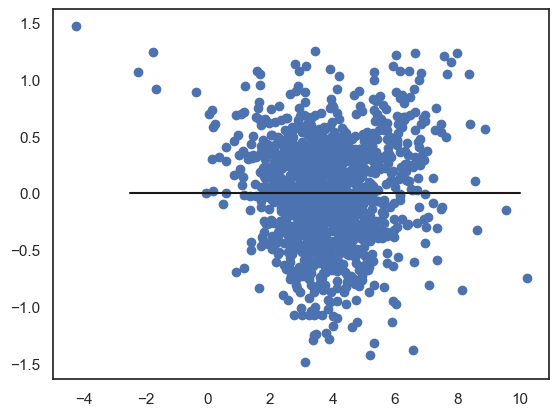

In [23]:
plt.plot(df_X_train['PopDen_log'],df_X_train['res'],'bo')
plt.plot(np.arange(-2.5,10.5,.5),len(np.arange(-2.5,10.5,.5))*[0],'-k')

From graphing the Poverty % (U18) we can see that as we get to higher Poverty level the model is overestimating the crime. One way to account for this is do a log transformation of the data. 

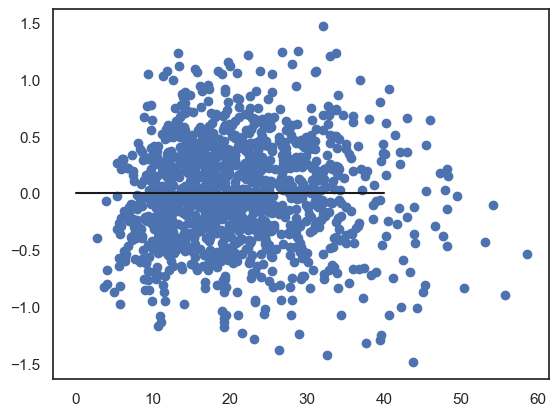

In [24]:
plt.plot(df_X_train['Poverty % (U18)'],df_X_train['res'],'bo')
plt.plot(np.arange(0,42,2),len(np.arange(0,42,2))*[0],'-k')

## Linear Regression with log

Next I will check to see if including the log transformation of Poverty % (U18) will fix this above issue. 

In [25]:
df['Poverty_log'] = np.log(df['Poverty % (U18)'])
#log transform Poverty % (U18)

In [26]:
df_X_train, df_X_test, y_train, y_test = train_test_split(df,df.Homicide_log, test_size=0.25, random_state=321)

In [27]:
scaler  = MinMaxScaler((0,1))
#Scale the data and train the model on the entire dataset.

atts = ['PopDen_log' ,'Poverty_log' ,'Firearms %']

X_train = scaler.fit_transform(df_X_train[atts])
model = LinearRegression()

model.fit(X_train,y_train)
y_pred = model.predict(X_train)
#train the model on the entire training set 

df_X_train['Pred'] = y_pred
df_X_train['res'] = y_train-y_pred
#Created the residuals and predicted column for furhter analysis. 

model.score(X_train,y_train)

0.5861387613115534

The training score only increased slightly but we can see that the coorelation between residuals and Poverty % (U18) is less pronounced. 

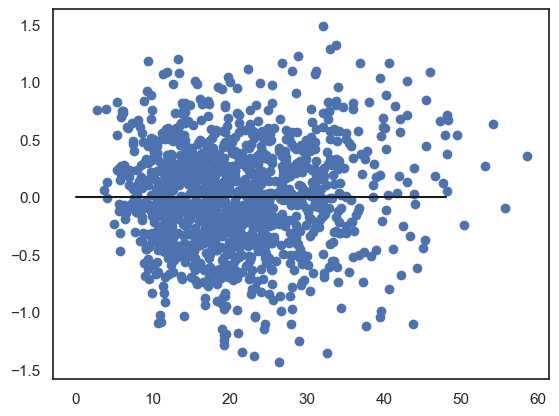

In [28]:
plt.plot(df_X_train['Poverty % (U18)'],df_X_train['res'],'bo')
plt.plot(np.arange(0,50,2),len(np.arange(0,50,2))*[0],'-k')

## Linear Regression with square 

Next we will add a quadratic interaction for the PopDen_log field next. 

In [29]:
atts = ['PopDen_log' ,'Poverty_log' ,'Firearms %']
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_X_train[atts])
new_col = np.reshape(X_train[:,0]**2,(-1,1))
#new_col.shape

X_train = np.hstack((X_train,new_col))
#add a 4th column that is the first column squared

In [30]:
X_train

array([[0.85566355, 0.40194428, 0.30622508, 0.73216012],
       [0.50111555, 0.66448929, 0.6908122 , 0.25111679],
       [0.54082407, 0.4379915 , 0.65075548, 0.29249068],
       ...,
       [0.44011292, 0.51511203, 0.58208682, 0.19369938],
       [0.7503095 , 0.63515201, 0.50288408, 0.56296435],
       [0.5780314 , 0.39494377, 0.4025252 , 0.3341203 ]])

In [31]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X_train,y_train)

y_pred = model.predict(X_train)
r2 = model.score(X_train,y_train)
r2

# we can see the accuracy has increase by a decent margin

Accuracy: 0.61 (+/- 0.06)


0.6242241163292936

In [32]:
1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

#Since we added another column of data it is a good idea also to check the adjusted r2 score to check for overfitting. 

0.6230302294868133

If there are no additional column that we want to add or any modifications needed to make toward our model we can score data against the test dataset. 

In [33]:
X_test = df_X_test[atts] 

X_test = scaler.transform(X_test)

new_col = np.reshape(X_test[:,0]**2,(-1,1))

X_test = np.hstack((X_test,new_col))

In [34]:
y_pred_test = model.predict(X_test)

model.score(X_test,y_test)

0.5682214676352522

We can see that the test score is .56, not too far off of our training score .62. Overall, I am fairly happy with this score, but we should do further analysis because there may be room for improvement. But lets first get a general sense of what the model is actually predicting. In the graph below we can see the contribution each variable has to the score at each point; remember our variables are scaled from 0-1. 

In [35]:
atts = ['PopDen_log' ,'Poverty_log' ,'Firearms %']
model.coef_

array([-7.45706747,  3.31407721,  1.05054718,  7.53143337])

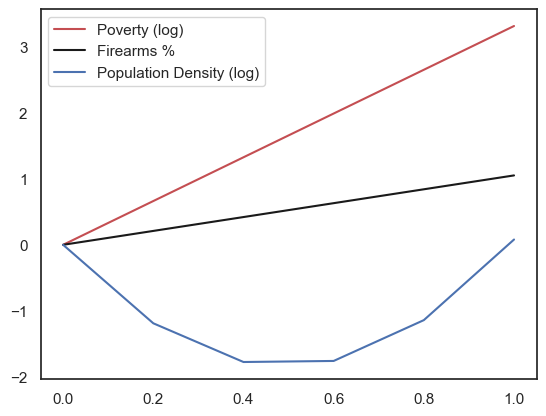

In [36]:
X = np.arange(0,1.2,.2)

plt.plot(X, X*3.314,'-r',label = 'Poverty (log)')
plt.plot(X,X*1.051,'-k', label = 'Firearms %')
plt.plot(X,X*-7.45 +(X**2)*7.53,'-b', label= 'Population Density (log)')
plt.legend(loc="upper left")

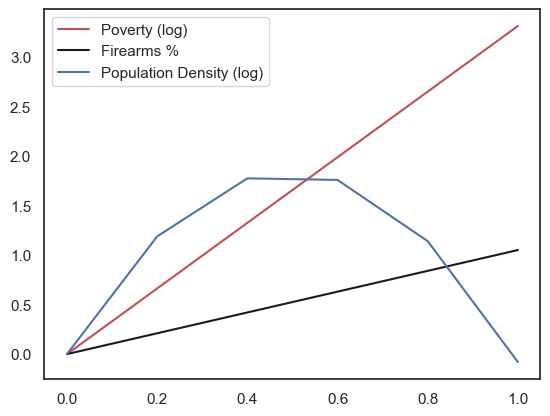

In [37]:
X = np.arange(0,1.2,.2)

plt.plot(X, X*3.314,'-r',label = 'Poverty (log)')
plt.plot(X,X*1.051,'-k', label = 'Firearms %')
plt.plot(X,X*7.45 +(X**2)*-7.53,'-b', label= 'Population Density (log)')
plt.legend(loc="upper left")

Something else that is worth looking at is a look to see if there is a coorelation between the residuals and our response variable. For both the training and testing sets we saw a clear positive coorelation between the two numbers. This indicates that there are unaccounted factors that can be added to improve the model. 

In [101]:
df_X_train['Pred'] = y_pred
df_X_train['res'] = y_train-y_pred

In [102]:
df_X_test['Pred'] = y_pred_test
df_X_test['res'] = y_test-y_pred_test


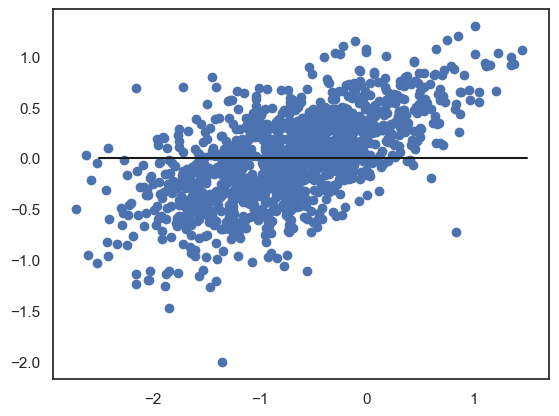

In [103]:
plt.plot(y_train, df_X_train['res'],'bo')
plt.plot(np.arange(-2.5,2,.5),len(np.arange(-2.5,2,.5))*[0],'-k')

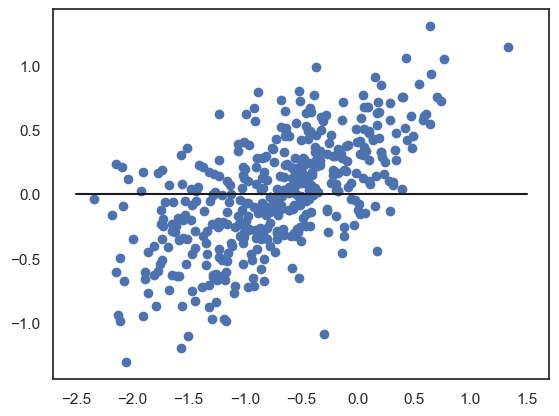

In [104]:
plt.plot(y_test, df_X_test['res'],'bo')
plt.plot(np.arange(-2.5,2,.5),len(np.arange(-2.5,2,.5))*[0],'-k')

Looking at the distrubution of residuals in the training and testing models we see a normal distrubution, which is ideal.  

<AxesSubplot:>

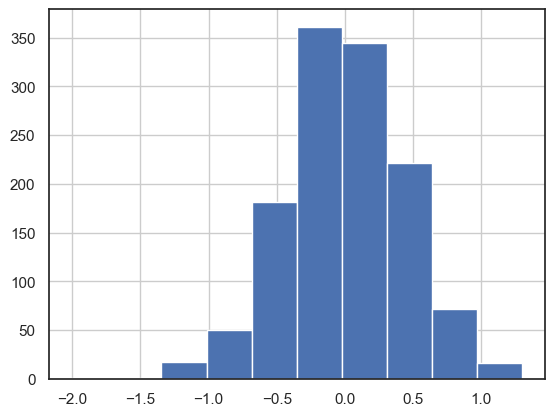

In [105]:
df_X_train['res'].hist()

In [111]:
df_X_test.sort_values(by = ['res']).head(10)
df_X_test.sort_values(by = ['res'], ascending = False).head(10)

,County,Poverty %,Poverty % (U18),MedHHInc,MedHHInc_log,PopDen_log,PopDen,Firearms %,Firearms_adj,Homicide_log,Homicide_adj,Imputed Data,Poverty_log,Pred,res
729,"Jackson County, MO",13.1,17.3,63282,11.055356,6.091264,441.979623,0.512373,0.928926,0.643975,1.904035,False,2.850707,-0.662558,1.306533
1190,"Petersburg city, VA",22.8,35.6,40682,10.613541,6.293163,540.861429,0.528302,0.796754,1.330935,3.784581,False,3.572346,0.190830,1.140105
1404,"St. Clair County, IL",13.3,20.2,66422,11.103784,5.041223,154.658989,0.565217,0.625443,0.429257,1.536115,False,3.005683,-0.629633,1.058889
1411,"St. John the Baptist Parish, LA",16.8,27.3,58548,10.977602,4.360151,78.268936,0.651163,0.580138,0.767697,2.154797,False,3.306887,-0.285118,1.052815
13,"Alameda County, CA",9.4,9.9,108971,11.598837,6.757812,860.757075,0.296837,0.275175,-0.372421,0.689064,False,2.292535,-1.361952,0.989531
744,"Jefferson County, AL",16.9,23.6,55210,10.918899,5.434819,229.251338,0.660770,0.875865,0.650890,1.917247,False,3.161247,-0.279941,0.930832
255,"Charleston County, SC",13.8,18.5,71755,11.181013,5.112139,166.025134,0.527778,0.760113,0.152617,1.164879,False,2.917771,-0.759417,0.912034
1638,"Williamsburg County, SC",21.2,33.4,40235,10.602493,2.575726,13.140854,0.500000,0.338686,0.543284,1.721651,False,3.508556,-0.316318,0.859602
1410,"St. James Parish, LA",17.0,23.3,60466,11.009837,3.530433,34.138742,0.550000,0.465413,0.204571,1.226999,False,3.148453,-0.640119,0.844690
471,"El Paso County, CO",9.6,11.5,79094,11.278392,4.827718,124.925569,0.521282,1.266229,-0.523978,0.592160,False,2.442347,-1.327425,0.803447


In [113]:
df_X_train.sort_values(by = ['res'], ascending = False).head(10)
#df_X_train.sort_values(by = ['res']).head(10)

,County,Poverty %,Poverty % (U18),MedHHInc,MedHHInc_log,PopDen_log,PopDen,Firearms %,Firearms_adj,Homicide_log,Homicide_adj,Imputed Data,Poverty_log,Pred,res
745,"Jefferson County, AR",20.3,28.8,46100,10.738568,3.442164,31.254515,0.654545,0.917311,1.012303,2.751932,False,3.360375,-0.287231,1.299534
1027,"Mississippi County, AR",23.9,31.2,41007,10.621498,2.910330,18.362858,0.540541,0.837353,0.852109,2.344587,False,3.440418,-0.346337,1.198447
741,"Jasper County, SC",16.1,28.0,54099,10.898571,2.799847,16.442123,0.590909,0.852507,0.756716,2.131266,False,3.332205,-0.403377,1.160093
1050,"Monterey County, CA",12.1,15.5,81404,11.307180,3.931206,50.968414,0.383408,0.361409,-0.104970,0.900352,False,2.740840,-1.261116,1.156146
34,"Anchorage Borough, AK",9.5,11.3,86152,11.363868,4.204697,67.000292,0.600871,1.275478,-0.221863,0.801025,False,2.424803,-1.322413,1.100550
1644,"Wilson County, TX",9.8,13.4,78794,11.274592,3.142151,23.153605,0.695652,0.920390,-0.002915,0.997089,False,2.595255,-1.080140,1.077225
1666,"Wyandotte County, KS",16.9,22.3,54943,10.914052,6.036563,418.452206,0.491228,0.784145,0.647079,1.909953,False,3.104587,-0.423440,1.070518
1194,"Phillips County, AR",35.7,45.9,32419,10.386500,2.357513,10.564648,0.800000,1.305471,1.456148,4.289404,False,3.826465,0.397286,1.058862
1327,"San Joaquin County, CA",12.3,15.7,79598,11.284744,5.313398,203.038982,0.407059,0.432926,-0.006543,0.993478,False,2.753661,-1.050027,1.043484
1008,"Mercer County, NJ",10.4,11.8,86499,11.367888,6.452672,634.394959,0.236066,0.177102,-0.290670,0.747762,False,2.468100,-1.324148,1.033478


## Regression Tree

I also decided to run the data using a Regression Tree instead of a multivariate  Regression. Here I will follow a similiar procress, first using cross validation for hyperparamters selection. 

In [139]:
X_train = df_X_train[atts]

In [140]:
for i in [2,4,6,10,20,40,60,80]:
    regressor = DecisionTreeRegressor(min_samples_leaf = i,random_state = 12) 
    scores = cross_val_score(regressor, df_X_train[atts], y_train, cv = 5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
   

#cross validation for hyperparamter selection

Accuracy: 0.40 (+/- 0.09)
Accuracy: 0.47 (+/- 0.14)
Accuracy: 0.53 (+/- 0.07)
Accuracy: 0.57 (+/- 0.09)
Accuracy: 0.60 (+/- 0.08)
Accuracy: 0.58 (+/- 0.11)
Accuracy: 0.58 (+/- 0.09)
Accuracy: 0.56 (+/- 0.11)


Next we will run the best preforming hyperparamter value (20) and run it against the entire dataset. Then we will find our score for the testing dataset. 

In [141]:
regressor = DecisionTreeRegressor(min_samples_leaf = 20,random_state = 0) 

X_train = df_X_train[atts]

regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_train)

regressor.score(X_train, y_train)

0.687680228846637

In [142]:
X_test = df_X_test[atts] 

y_pred_test = regressor.predict(X_test)

regressor.score(X_test,y_test)

0.522443498987701

While our training set preformed about the same, our testing score is slightly lower compared to our Regression model. We can also graph our residuals again and see the same positive coorelation that we saw with our regression model, once again indicating that we can improve our model by bringing in different attributes. 

In [147]:
df_X_test['Pred'] = y_pred_test
df_X_test['res'] = y_test-y_pred_test

df_X_train['Pred'] = y_pred
df_X_train['res'] = y_train-y_pred

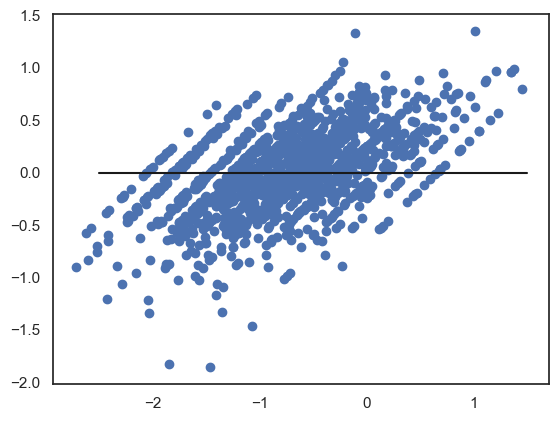

In [148]:
plt.plot(y_train, df_X_train['res'],'bo')
plt.plot(np.arange(-2.5,2,.5),len(np.arange(-2.5,2,.5))*[0],'-k')

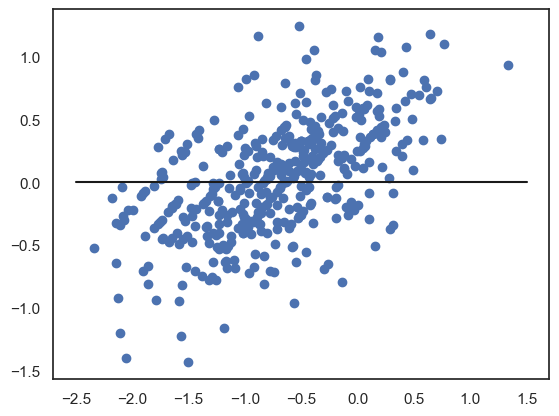

In [149]:
plt.plot(y_test, df_X_test['res'],'bo')
plt.plot(np.arange(-2.5,2,.5),len(np.arange(-2.5,2,.5))*[0],'-k')

This brings me to end of my analysis. The biggest takeaways are that Poverty has the most effect on Homicide rate. It also appears that areas with very and very high population density tend to have the most homicides. Finally, there is a slight association between gun ownership and homicide rate. The model could likley be improved by introducing more data, and also more relaible data (remember gun ownership is being determined via a proxy). Some potential datapoints that could be introduced are education data, mental health data, and local government spending data. 